# Visualizations
All visualizations can be generated without running full model training.


In [47]:
import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pathlib import Path
from collections import defaultdict
from torch_geometric.data import HeteroData
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


In [69]:
# Configuration
GRAPHS_DIR = Path("~/Desktop/CS224W/graphs").expanduser()
#SITES = ["crafts.stackexchange.com", "arduino.stackexchange.com", "outdoors.stackexchange.com", "economics.stackexchange.com", "math.stackexchange.com" , "music.stackexchange.com", "movies.stackexchange.com"]
SITES = ["outdoors.stackexchange.com", "math.stackexchange.com" , "music.stackexchange.com"]


Decide which sites to run based on this

In [78]:
def analyze_community_sizes(sites: list):
    """Analyze and categorize each site by typical community size."""
    
    print("="*80)
    print("COMMUNITY SIZE ANALYSIS")
    print("="*80)
    
    site_stats = []
    
    for site in sites:
        months = get_all_months(site)
        if not months:
            continue
        
        user_counts = []
        tag_counts = []
        
        for month in months:
            graph = load_graph(site, month)
            if graph is None:
                continue
            
            user_counts.append(graph['user'].num_nodes)
            tag_counts.append(graph['tag'].num_nodes)
        
        if user_counts:
            avg_users = np.mean(user_counts)
            max_users = np.max(user_counts)
            min_users = np.min(user_counts)
            
            # Categorize
            if avg_users < 100:
                size_cat = "SMALL"
            elif avg_users < 300:
                size_cat = "MEDIUM"
            else:
                size_cat = "LARGE"
            
            site_stats.append({
                'site': site.replace('.stackexchange.com', ''),
                'size_category': size_cat,
                'avg_users': avg_users,
                'min_users': min_users,
                'max_users': max_users,
                'avg_tags': np.mean(tag_counts),
                'num_months': len(months)
            })
    
    # Sort by average users
    site_stats.sort(key=lambda x: x['avg_users'], reverse=True)
    
    print(f"\n{'Site':<15} {'Category':<10} {'Avg Users':<12} {'Range':<20} {'Avg Tags':<12} {'Months':<8}")
    print("-"*80)
    
    for stat in site_stats:
        print(f"{stat['site']:<15} {stat['size_category']:<10} "
              f"{stat['avg_users']:>10.1f}  "
              f"{stat['min_users']:>4.0f} - {stat['max_users']:<4.0f}      "
              f"{stat['avg_tags']:>10.1f}  "
              f"{stat['num_months']:>6}")
    
    print("\n" + "="*80)
    
    return site_stats


def compare_size_trajectories(sites: list, small_site: str, medium_site: str, large_site: str):
    """Compare topology evolution for three representative sites."""
    
    comparison_sites = [small_site, medium_site, large_site]
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 14))
    
    metrics_to_plot = [
        ('num_users', 'Number of Users'),
        ('num_tags', 'Number of Tags'),
        ('tag_network_density', 'Tag Network Density'),
        ('avg_tag_degree', 'Average Tag Degree'),
        ('tag_clustering_coeff', 'Clustering Coefficient'),
        ('qpd', 'Questions Per Day'),
        ('answer_rate', 'Answer Rate'),
        ('retention', 'User Retention'),
        ('avg_user_contributions', 'Avg User Contributions')
    ]
    
    colors = {'small': 'blue', 'medium': 'orange', 'large': 'red'}
    size_labels = {small_site: 'small', medium_site: 'medium', large_site: 'large'}
    
    for idx, (metric_key, metric_label) in enumerate(metrics_to_plot):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        for site in comparison_sites:
            months = get_all_months(site)
            if not months:
                continue
            
            data = []
            month_indices = []
            
            for i, month in enumerate(months):
                graph = load_graph(site, month)
                if graph is None:
                    continue
                
                month_indices.append(i)
                
                if metric_key in ['qpd', 'answer_rate', 'retention']:
                    # Health metrics from graph.y
                    metrics_dict = extract_community_metrics(graph)
                    data.append(metrics_dict.get(metric_key, 0))
                else:
                    # Topology metrics
                    topo = compute_graph_topology_metrics(graph)
                    data.append(topo.get(metric_key, 0))
            
            if data:
                size_cat = size_labels[site]
                ax.plot(month_indices, data, 
                       label=f"{site.replace('.stackexchange.com', '')} ({size_cat})",
                       color=colors[size_cat], linewidth=2, alpha=0.8)
        
        ax.set_title(metric_label, fontsize=11, fontweight='bold')
        ax.set_xlabel('Month Index', fontsize=9)
        ax.set_ylabel(metric_label, fontsize=9)
        ax.legend(fontsize=8, loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Community Evolution: Small vs Medium vs Large', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Run the analysis
site_stats = analyze_community_sizes(SITES)

# Based on the output, choose representative sites
# You'll need to run this first, then uncomment and adjust the comparison below

COMMUNITY SIZE ANALYSIS

Site            Category   Avg Users    Range                Avg Tags     Months  
--------------------------------------------------------------------------------
math            LARGE          6293.1     1 - 10004          1106.5     166
music           MEDIUM          237.4    46 - 417            169.9     159
outdoors        SMALL            68.4     1 - 143             88.4     148



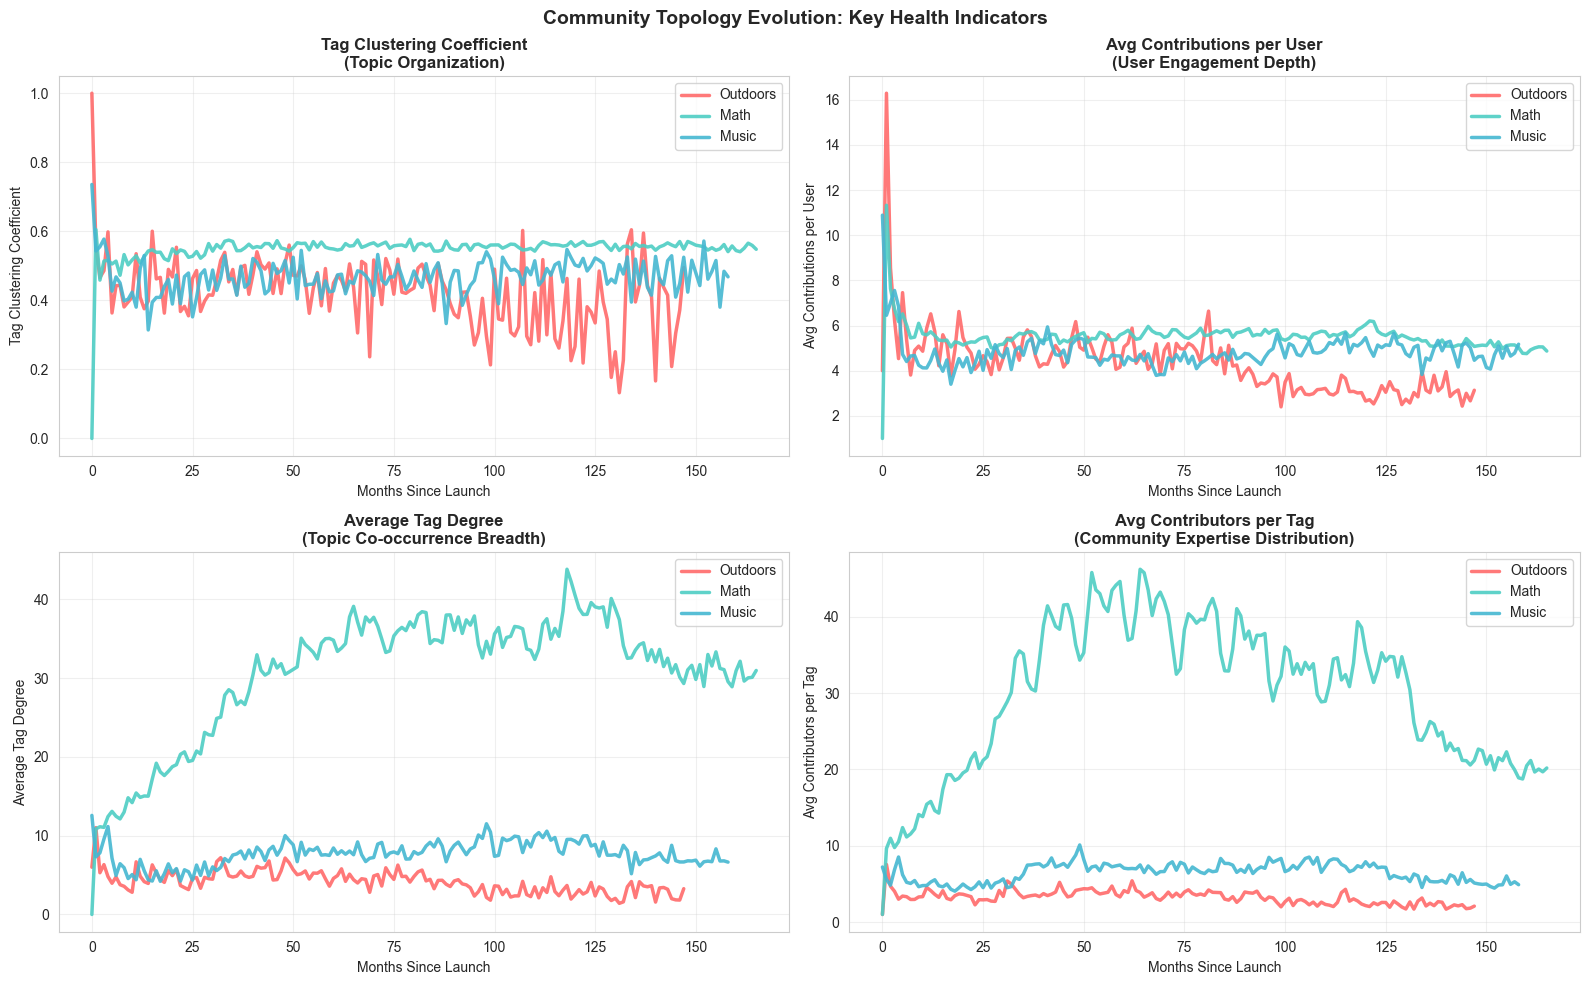

In [76]:
def plot_focused_topology_evolution(sites: list):
    """Plot 4 key topology metrics that tell the community health story."""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    # Select 4 most interpretable metrics
    topology_metrics = [
        ('tag_clustering_coeff', 'Tag Clustering Coefficient', 'Topic Organization'),
        ('avg_user_contributions', 'Avg Contributions per User', 'User Engagement Depth'),
        ('avg_tag_degree', 'Average Tag Degree', 'Topic Co-occurrence Breadth'),
        ('avg_contributors_per_tag', 'Avg Contributors per Tag', 'Community Expertise Distribution')
    ]
    
    # Brighter, more vibrant colors
    color_palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
    
    for site_idx, site in enumerate(sites):
        months = get_all_months(site)
        if not months:
            continue
        
        # Extract clean site name
        site_label = site.replace('.stackexchange.com', '').title()
        
        data = defaultdict(list)
        month_list = []
        
        for month in months:
            graph = load_graph(site, month)
            if graph is None:
                continue
            
            topo_metrics = compute_graph_topology_metrics(graph)
            month_list.append(month)
            
            for metric_key, _, _ in topology_metrics:
                data[metric_key].append(topo_metrics.get(metric_key, 0))
        
        # Plot each metric
        for idx, (metric_key, metric_label, subtitle) in enumerate(topology_metrics):
            ax = axes[idx]
            
            if data[metric_key]:
                ax.plot(range(len(month_list)), data[metric_key], 
                       label=site_label, 
                       color=color_palette[site_idx % len(color_palette)],
                       linewidth=2.5, alpha=0.9)
                
                ax.set_title(f'{metric_label}\n({subtitle})', 
                           fontsize=12, fontweight='bold')
                ax.set_xlabel('Months Since Launch', fontsize=10)
                ax.set_ylabel(metric_label, fontsize=10)
                ax.legend(fontsize=10, loc='best')
                ax.grid(True, alpha=0.3)
    
    plt.suptitle('Community Topology Evolution: Key Health Indicators', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_focused_topology_evolution(SITES)

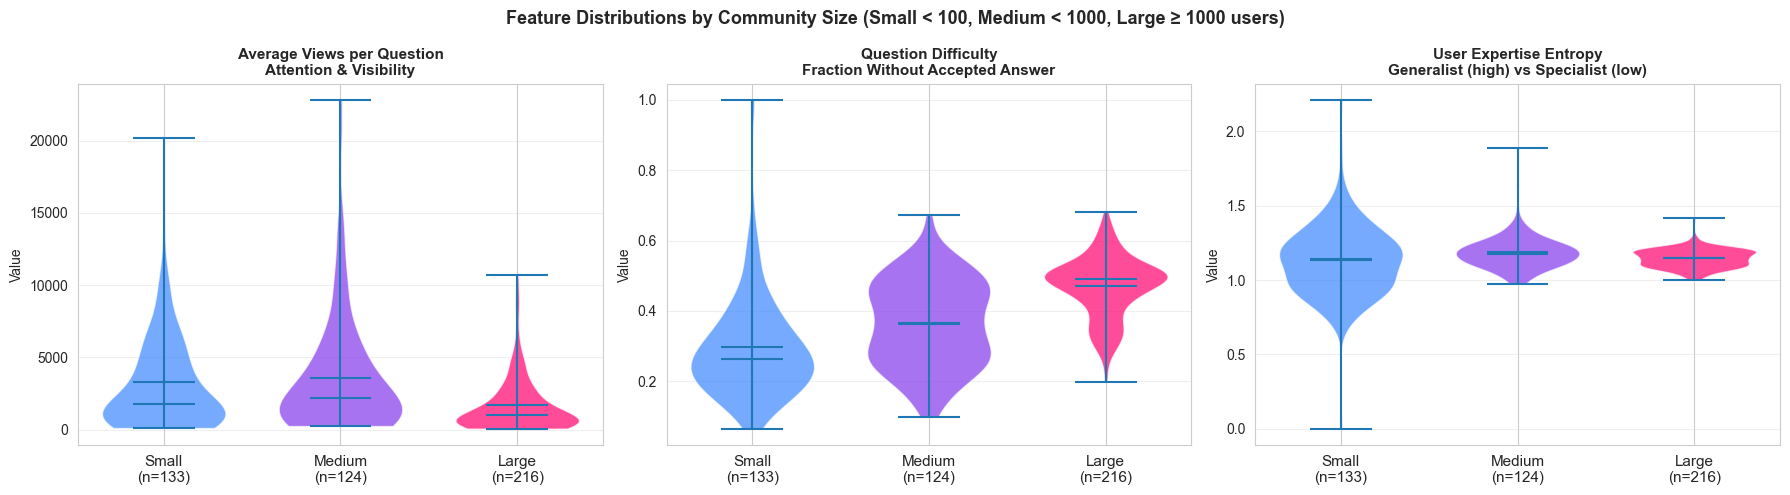

In [73]:
def plot_focused_feature_distributions(sites: list):
    """Plot 3 carefully selected features that show clear size-based patterns."""
    
    # Collect all data
    data_by_size = {
        'Small': {'features': []},
        'Medium': {'features': []},
        'Large': {'features': []}
    }
    
    for site in sites:
        months = get_all_months(site)
        for month in months:
            graph = load_graph(site, month)
            if graph is None or graph['tag'].x is None or graph['user'].x is None:
                continue
            
            num_users = graph['user'].num_nodes
            size_category = categorize_community_size(num_users)
            
            # Extract specific features
            tag_features = graph['tag'].x.numpy()
            user_features = graph['user'].x.numpy()
            
            # Tag: avg_views (index 2), difficulty (index 4)
            avg_views = tag_features[:, 2].mean()
            difficulty = tag_features[:, 4].mean()
            
            # User: expertise_entropy (index 3)
            expertise_entropy = user_features[:, 3].mean()
            
            data_by_size[size_category]['features'].append([
                avg_views, difficulty, expertise_entropy
            ])
    
    # Convert to arrays
    for size in ['Small', 'Medium', 'Large']:
        if data_by_size[size]['features']:
            data_by_size[size]['features'] = np.array(data_by_size[size]['features'])
    
    # Create focused visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    feature_info = [
        (0, 'Average Views per Question', 'Attention & Visibility'),
        (1, 'Question Difficulty', 'Fraction Without Accepted Answer'),
        (2, 'User Expertise Entropy', 'Generalist (high) vs Specialist (low)')
    ]
    
    colors_map = {'Small': '#3A86FF', 'Medium': '#8338EC', 'Large': '#FF006E'}
    
    for idx, (feat_idx, title, subtitle) in enumerate(feature_info):
        ax = axes[idx]
        
        data_to_plot = []
        labels = []
        positions = []
        colors_list = []
        
        for pos, size in enumerate(['Small', 'Medium', 'Large']):
            if len(data_by_size[size]['features']) > 0:
                data_to_plot.append(data_by_size[size]['features'][:, feat_idx])
                labels.append(f"{size}\n(n={len(data_by_size[size]['features'])})")
                positions.append(pos)
                colors_list.append(size)
        
        if data_to_plot:
            parts = ax.violinplot(data_to_plot, positions=positions,
                                 showmeans=True, showmedians=True, widths=0.7)
            
            # Color the violins
            for pc, size in zip(parts['bodies'], colors_list):
                pc.set_facecolor(colors_map[size])
                pc.set_alpha(0.7)
            
            ax.set_xticks(positions)
            ax.set_xticklabels(labels, fontsize=11)
            ax.set_title(f'{title}\n{subtitle}', fontsize=11, fontweight='bold')
            ax.set_ylabel('Value', fontsize=10)
            ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Feature Distributions by Community Size (Small < 100, Medium < 1000, Large ≥ 1000 users)', 
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_focused_feature_distributions(SITES)

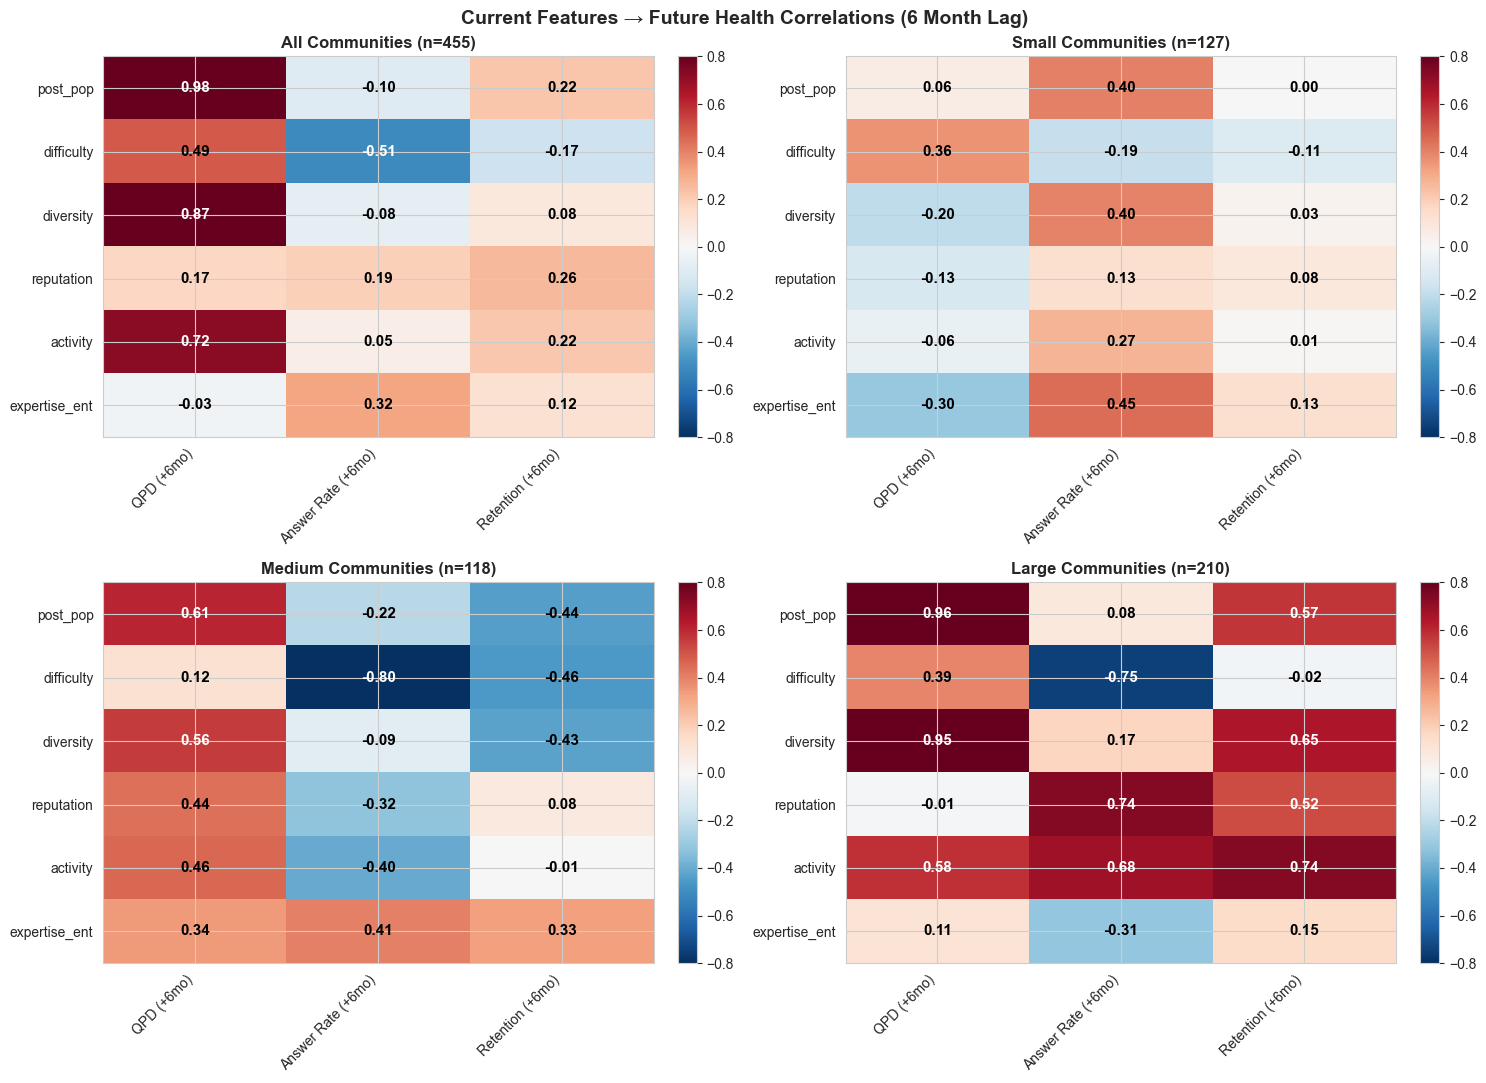

In [74]:
def plot_correlation_without_growth(sites: list):
    """Correlation heatmap excluding growth metric."""
    
    all_features = []
    all_future_metrics = []
    site_sizes = []
    
    feature_names = ['post_pop', 'difficulty', 'diversity',
                     'reputation', 'activity', 'expertise_ent']
    
    for site in sites:
        months = get_all_months(site)
        
        for i, month in enumerate(months[:-6]):
            graph_current = load_graph(site, month)
            graph_future = load_graph(site, months[i + 6])
            
            if (graph_current is None or graph_future is None or 
                graph_current['tag'].x is None or graph_current['user'].x is None):
                continue
            
            tag_feat = graph_current['tag'].x.numpy()
            user_feat = graph_current['user'].x.numpy()
            
            features = [
                tag_feat[:, 0].mean(),  # post_popularity
                tag_feat[:, 4].mean(),  # difficulty
                tag_feat[:, 5].mean(),  # diversity
                user_feat[:, 0].mean(), # reputation
                user_feat[:, 2].mean(), # activity
                user_feat[:, 3].mean()  # expertise_entropy
            ]
            
            future_metrics = extract_community_metrics(graph_future)
            if not future_metrics:
                continue
            
            # Only 3 metrics now (no growth)
            all_features.append(features)
            all_future_metrics.append([
                future_metrics.get('qpd', 0),
                future_metrics.get('answer_rate', 0),
                future_metrics.get('retention', 0)
            ])
            site_sizes.append(categorize_community_size(graph_current['user'].num_nodes))
    
    if not all_features:
        print("No data collected for correlation analysis")
        return
    
    all_features = np.array(all_features)
    all_future_metrics = np.array(all_future_metrics)
    site_sizes = np.array(site_sizes)
    
    metric_names = ['QPD (+6mo)', 'Answer Rate (+6mo)', 'Retention (+6mo)']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 11))
    axes = axes.flatten()
    
    categories = ['All', 'Small', 'Medium', 'Large']
    
    for idx, category in enumerate(categories):
        ax = axes[idx]
        
        if category == 'All':
            mask = np.ones(len(site_sizes), dtype=bool)
        else:
            mask = site_sizes == category
        
        if mask.sum() < 10:
            ax.text(0.5, 0.5, f'Insufficient data\n{category} (n={mask.sum()})', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{category} Communities (n={mask.sum()})', fontweight='bold')
            continue
        
        features_subset = all_features[mask]
        metrics_subset = all_future_metrics[mask]
        
        correlations = np.zeros((len(feature_names), len(metric_names)))
        for i in range(len(feature_names)):
            for j in range(len(metric_names)):
                valid_idx = ~(np.isnan(features_subset[:, i]) | np.isnan(metrics_subset[:, j]))
                if valid_idx.sum() > 1:
                    correlations[i, j] = np.corrcoef(
                        features_subset[valid_idx, i], 
                        metrics_subset[valid_idx, j]
                    )[0, 1]
                else:
                    correlations[i, j] = 0
        
        im = ax.imshow(correlations, cmap='RdBu_r', aspect='auto', vmin=-0.8, vmax=0.8)
        
        ax.set_xticks(range(len(metric_names)))
        ax.set_xticklabels(metric_names, rotation=45, ha='right', fontsize=10)
        ax.set_yticks(range(len(feature_names)))
        ax.set_yticklabels(feature_names, fontsize=10)
        
        for i in range(len(feature_names)):
            for j in range(len(metric_names)):
                text = ax.text(j, i, f'{correlations[i, j]:.2f}',
                             ha="center", va="center", 
                             color="white" if abs(correlations[i, j]) > 0.5 else "black", 
                             fontsize=11, fontweight='bold')
        
        ax.set_title(f'{category} Communities (n={mask.sum()})', fontweight='bold', fontsize=12)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.suptitle('Current Features → Future Health Correlations (6 Month Lag)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_correlation_without_growth(SITES)